In [1]:
import numpy as np
import pandas as pd
import clima_anom as ca
import cartopy

from descartes import PolygonPatch

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

from shapely.geometry import Polygon, Point
import rtree as rt

import os
import glob
import sys
module_path = os.path.abspath(os.path.join('src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
Ano = '2018'
Mes = '03'
Num_dias, ds, de, month_name = ca.days_number(Ano,Mes)

Ano:  2018
Mes:  Marzo


In [5]:
# America do Sul
resolution = 0.5
grid_r = '05x05'

# resolution = 1
# grid_r = '1x1'

print('Resolucion: ',grid_r)

# America do Sul
lon_new = np.arange(-85,-30,resolution)
lat_new = np.arange(-45,10,resolution)
# Grilla America do Sul
lons = np.arange(-85,-30+resolution,resolution)
lats = np.arange(-45,10+resolution,resolution)

# # Sao Paulo
# resolution = 14/111
# lon_new = np.arange(-49,-45,resolution)
# lat_new = np.arange(-25,-21,resolution)
# # Grilla Sao Paulo
# lons = np.arange(-49,-45+resolution,resolution)levels = np.arange(0,34,2)
cmap = plt.cm.Spectral_r

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(10,10.5),dpi=150)
gs = gridspec.GridSpec(2,2)

ax1 = plt.subplot(gs[0, 0], projection = proj)
# lats = np.arange(-25,-21+resolution,resolution)

grids = list()
for lat in range(lats.size-1):
    for lon in range(lons.size-1):
        lu = Point(lons[lon], lats[lat])
        ru = Point(lons[lon+1], lats[lat])
        rb = Point(lons[lon+1], lats[lat+1])
        lb = Point(lons[lon], lats[lat+1])
        poly = Polygon((lu, ru, rb, lb, lu))
        grids.append(poly)

grid = np.reshape(grids, (lats.size-1, lons.size-1))

Resolucion:  05x05


In [15]:
# lista = glob.glob('/mnt/Data/GLM/Data/5min/*.csv')
lista = glob.glob('/mnt/Data/Data/GLM/SA/Point/'+Ano+'/'+Mes+'/*.csv')
lista = sorted(lista)
tempos = len(lista)
print(tempos)

2976


In [19]:
Densidad = np.zeros([tempos,len(lat_new),len(lon_new)])
count = 0
for i in range(tempos): 

    if os.path.exists(lista[i]):

        if i % 100 == 0 or i == tempos-1:
            print(i+1,'de',tempos,' ',lista[i])

        data_in = pd.read_csv(lista[i])
        data = pd.DataFrame({'Lat':data_in['Lat'],'Lon':data_in['Lon']})

        tree = rt.index.Index()

        for i, row in data.iloc[:,:].iterrows():
            tree.insert(i, Point(row.Lon, row.Lat).bounds)

        mapping = list()

        for g in grids:
            matches = list(tree.intersection(g.bounds))
            mapping.append(len(matches))

        density = np.reshape(mapping, (lats.size-1, lons.size-1))

    else:
        print('   ',lista[i],'No Existe')
        density = np.zeros([len(lat_new),len(lon_new)])

    Densidad[count,:,:] = density
    count = count + 1

0 de 2976   /mnt/Data/Data/GLM/SA/Point/2018/03/Flash_15min_2018_03_01_00_00_14.csv
100 de 2976   /mnt/Data/Data/GLM/SA/Point/2018/03/Flash_15min_2018_03_02_01_00_14.csv
200 de 2976   /mnt/Data/Data/GLM/SA/Point/2018/03/Flash_15min_2018_03_03_02_00_14.csv
300 de 2976   /mnt/Data/Data/GLM/SA/Point/2018/03/Flash_15min_2018_03_04_03_00_14.csv
400 de 2976   /mnt/Data/Data/GLM/SA/Point/2018/03/Flash_15min_2018_03_05_04_00_14.csv
500 de 2976   /mnt/Data/Data/GLM/SA/Point/2018/03/Flash_15min_2018_03_06_05_00_14.csv
600 de 2976   /mnt/Data/Data/GLM/SA/Point/2018/03/Flash_15min_2018_03_07_06_00_14.csv
700 de 2976   /mnt/Data/Data/GLM/SA/Point/2018/03/Flash_15min_2018_03_08_07_00_14.csv
800 de 2976   /mnt/Data/Data/GLM/SA/Point/2018/03/Flash_15min_2018_03_09_08_00_14.csv
900 de 2976   /mnt/Data/Data/GLM/SA/Point/2018/03/Flash_15min_2018_03_10_09_00_14.csv
1000 de 2976   /mnt/Data/Data/GLM/SA/Point/2018/03/Flash_15min_2018_03_11_10_00_14.csv
1100 de 2976   /mnt/Data/Data/GLM/SA/Point/2018/03/Flas

In [25]:
file_name_out = '/mnt/Data/Data/GLM/SA/Grid/GLM_'+Ano+'_'+Mes+'_15min_'+grid_r+'.nc'
print(file_name_out)

/mnt/Data/Data/GLM/SA/Grid/GLM_2018_03_15min_05x05.nc


In [26]:
info = {'file': file_name_out,
        'title': 'GLM flash 0.5x0.5', 
        'year_start':int(Ano),'month_start':int(Mes),'day_start':ds,'hour_start':0,'minute_start':0,
        'year_end':int(Ano),'month_end':int(Mes),'day_end':de,'hour_end':23,'minute_end':59,
        'time_frequency': 'minutely', 
        'time_interval': 15,
        'var_name': 'flash', 
        'var_units': 'flash/0.5x0.5'} 

In [28]:
ca.create_netcdf(info,Densidad,lat_new,lon_new)

Time Start: 2018-03-01 00:00:00
Time End: 2018-03-31 23:45:00
Time Frequency: minutely
Time Lenght: 2976

File created in:  /mnt/Data/Data/GLM/SA/Grid/GLM_2018_03_15min_05x05.nc
File title:  GLM flash 0.5x0.5
var title:  flash
var units:  flash/0.5x0.5


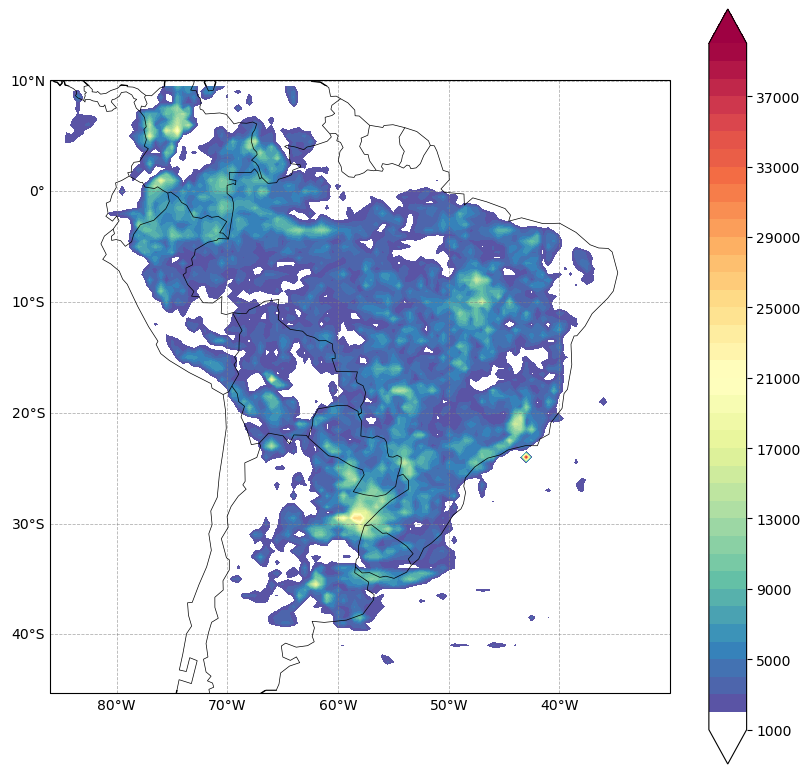

In [49]:
lon2d, lat2d = np.meshgrid(lon_new,lat_new)
test_sum = np.sum(Densidad,axis=0)

levels = np.arange(1000,41000,1000)

cmap = plt.cm.Spectral_r
tbar = ca.colorbar_middle_white(cmap, -1, 39)

fig = plt.figure(figsize=(10,10),dpi=100)
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
ax.coastlines()
ax.add_feature(cfeature.COASTLINE,linewidth=0.5,color='black',zorder=4)
ax.add_feature(cfeature.BORDERS,linewidth=0.5,color='black',zorder=4)
ax.set_extent([-86,-30,-42,9])
a1 = ax.contourf(lon_new,lat_new,test_sum,cmap=tbar,levels=levels,extend='both')
gl = ax.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
plt.colorbar(a1)